# Testing Data Generation

In [2]:
import simulate_data
import scan

In [9]:
N = 1000
M = 4
D = 71
T = 1000
seed=0

num_SM_events = 5
SM_total_spikes = 10
noise = 200

params = {
    'N':N,
    'M':M,
    'D':D,
    'T':T,
    'seed':seed,
    'num_SM_events':num_SM_events,
    'SM_total_spikes':SM_total_spikes,
    'noise':noise
}

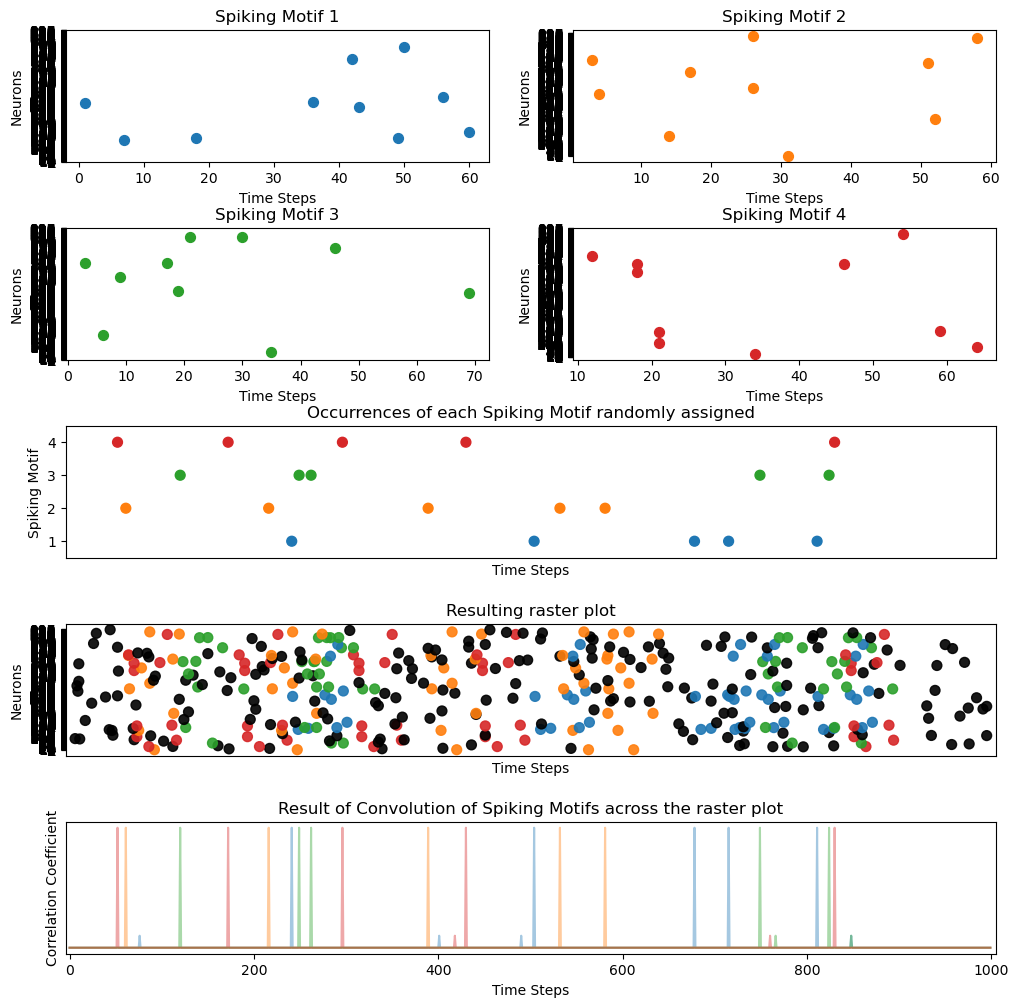

In [10]:
A_dense, A_sparse, B_dense, B_sparse, K_dense, K_sparse = simulate_data.generate_synthetic_data(params, plot=True)

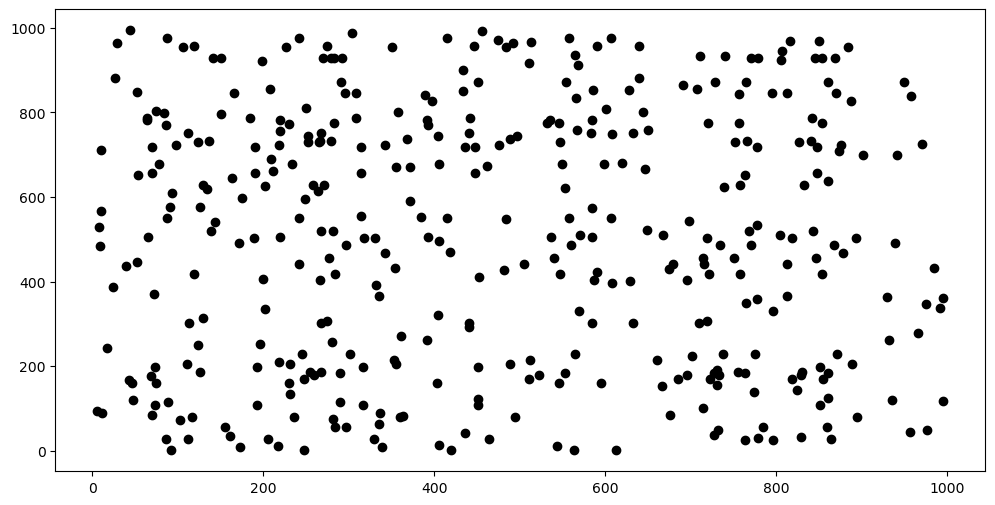

In [11]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
plt.scatter(A_sparse[1],A_sparse[0],c='black')
plt.show()